In [4]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import statsmodels.api as sm
import requests
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
import itertools
np.random.seed(9876789)


#so we can see all 160 countries
pd.set_option('display.max_rows', 161)
import os
anal=pd.read_csv('data/20200515_complete.csv')


In [128]:
#datasets

#Coronavirus Government Response Tracker https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker
#data description: https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md
#data source:https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker
#data file: https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv


# freedom house: https://freedomhouse.org/report/freedom-world 
# data source: https://freedomhouse.org/sites/default/files/2020-02/2020_All_Data_FIW_2013-2020.xlsx
#filename: 2020_All_Data_FIW_2013-2020.csv
#C/T? indicates whether the entry is a country (c) or territory (t)										
#F=Free, PF=Partly Free, NF=Not Free										
#PR Rating=Political Rights Rating										
#CL Rating=Civil Liberties Rating										
#A =aggregate score for the A. Electoral Process subcategory										
#B =aggregate score for the B. Political Pluralism and Participation subcategory										
#C =aggregate score for the C. Functioning of Government subcategory										
#Add Q (Add B)=score for Additional Discretionary Question (B)										
#Add A=score for Additional Discretionary Question A										
#PR =aggregate score for the Political Rights category										
#D =aggregate score for the D. Freedom of Expression and Belief subcategory										
#E =aggregate score for the E. Associational and Organizational Rights subcategory										
#F =aggregate score for the F. Rule of Law subcategory										
#G =aggregate score for te G. Personal Autonomy and Individual Rights subcategory										
#CL =aggregate score for the Civil Liberties category										
#Total =aggregate score for all categories										
#higher, better

#reporters without frontiers
#https://rsf.org/en/detailed-methodology
#data source: https://rsf.org/en/ranking_table/
#filename: index_2020_-_pour_import_1_1_-_index_goof_2020_-_pour_import_1_1.csv

#latest case and death per capita, and gdp/capita fro our world in data:
#description:https://ourworldindata.org/coronavirus-data 
#data source:https://covid.ourworldindata.org/data/owid-covid-data.csv


#read latest occgrt data, if cannot, read up latest from data dir
try:
    print("reading OxCGRT dataset from the net...")
    OxCGRT=requests.get('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
    print('download success!', len(OxCGRT.text))
    with open('data/OxCGRT_latest.csv','w') as o:
        o.write(OxCGRT.text)
    print("success!")
except:
    print("failed to read latest dataset, reading it from data dir. reaaqding latest, from %s", str(os.path.getmtime('data/OxCGRT_latest.csv') ) )
OxCGRT_df= pd.read_csv('data/OxCGRT_latest.csv')
OxCGRT_df['datetime']= OxCGRT_df['Date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d'))
print ("oxCGRT dataset lenght: %i rows" %len(OxCGRT_df))

#freedom house
fh_df=pd.read_csv('data/2020_All_Data_FIW_2013-2020.csv')

#RwF
rwf_df=pd.read_csv('data/index_2020_-_pour_import_1_1_-_index_goof_2020_-_pour_import_1_1.csv')

#reading OWID data
try:
    print("reading OWID dataset from the net...")
    owid=requests.get('https://covid.ourworldindata.org/data/owid-covid-data.csv', timeout=0.1)
    with open('data/owid-covid-data.csv','w') as o:
        o.write(owid.text)
    print("success!")
except:
    print("failed to read latest dataset, reading it from data dir. reaaqding latest, from %s", str(os.path.getmtime('data/OxCGRT_latest.csv') ) )
owid_df= pd.read_csv('data/owid-covid-data.csv')
print ("owid dataset lenght: %i rows" %len(owid_df)) 


#date of data
now='2020-05-16'


reading OxCGRT dataset from the net...
download success! 3253775
success!
oxCGRT dataset lenght: 22625 rows
reading OWID dataset from the net...
success!
owid dataset lenght: 17635 rows


In [129]:
def firstcasedate(name,col):
    a=OxCGRT_df[OxCGRT_df.CountryName==name]
    b= a[a[col]==a[(a[col].notna())&(a[col].gt(0))][col].min()][0:1].datetime
    try:
        return b.values.astype('datetime64[D]')[0]
    except:
        return np.NaN

# return (in days) the difference between 
#the date of first introduction of a measure and the date of  first reported case
def dayssincefirstcase(name,col, val):
    a=OxCGRT_df[OxCGRT_df.CountryName==name]
    b= a[a[col]==val][0:1].datetime
    try:
        c=anal[anal.country==name]['firstcase']
    except:
        return np.NaN
    try:
        days=(b.values[0]-c)/ np.timedelta64(1, 'D')
        if days.values[0]>anal[anal.country==name][col.replace(' ','_')+'_'+str(int(val)+1)].values[0]: #if a lower level lockdown has a later date
            return np.NaN
        else:
            return days.values[0]
    except:
        try:
            days=(b.values[0]-c)/ np.timedelta64(1, 'D')
            return  days.values[0]
        except:
            return np.NaN
    
colnames=[ "C1_School closing_1",
 "C1_School closing_2",
 "C1_School closing_3",
 "C2_Workplace closing_1",
 "C2_Workplace closing_2",
 "C2_Workplace closing_3",
 "C3_Cancel public events_1",
 "C3_Cancel public events_2",
 "C4_Restrictions on gatherings_1",
 "C4_Restrictions on gatherings_2",
 "C4_Restrictions on gatherings_3",
 "C4_Restrictions on gatherings_4",
 "C5_Close public transport_1" ,
 "C5_Close public transport_2" ,
 "C6_Stay at home requirements_1" ,
 "C6_Stay at home requirements_2" ,
 "C6_Stay at home requirements_3" ,
 "C7_Restrictions on internal movement_1",
 "C7_Restrictions on internal movement_2",
 "C8_International travel controls_1",
 "C8_International travel controls_2",
 "C8_International travel controls_3",
 "C8_International travel controls_4"]

In [130]:
#build anal df
anal=pd.DataFrame()
anal[['country','ISO']]=OxCGRT_df[['CountryName','CountryCode']].drop_duplicates()
anal['firstcase']=anal['country'].apply(firstcasedate, args=('ConfirmedCases',))
anal['firstdeath']=anal['country'].apply(firstcasedate, args=('ConfirmedDeaths',))

#add owid macro data
anal=pd.merge(anal, owid_df[owid_df.date==now], how="left", left_on="ISO", right_on="iso_code")

#add rwf data
anal=pd.merge(anal, rwf_df[['ISO','Score 2020']], on="ISO")

#add fh data
anal=pd.merge(anal,fh_df[fh_df.Edition==2020][['Country/Territory','Region','Status','Total']], how="left", left_on="country", right_on="Country/Territory")

#add max stringencyindex, and days to get there 
anal=pd.merge(anal, pd.DataFrame(OxCGRT_df.groupby('CountryCode').StringencyIndexForDisplay.max()), left_on="ISO", right_on="CountryCode")
anal['daystomoststingent']=anal['country'].apply(lambda x:dayssincefirstcase(x,'StringencyIndexForDisplay', anal[anal.country==x].StringencyIndexForDisplay.values[0])) 

#add gov action delays
for c in colnames[::-1]:
    print(c)
    anal[c.replace(' ','_')]=anal['country'].apply(dayssincefirstcase, args=(c[:-2], int(c[-1:]))) 

anal.drop(columns=['iso_code', 'location', 'date','Country/Territory'], inplace=True)
anal.rename(columns={'Score 2020':'freepress', 'Total':'democracy', 'StringencyIndexForDisplay':'stringencyindex','Status':'democracy_cat'}, inplace=True)

anal.freepress=anal.freepress.map(lambda x: float(x.replace(',','.')))
anal.total_cases_per_million=anal.total_cases_per_million.map(lambda x: round(x,0))
anal.total_deaths_per_million=anal.total_deaths_per_million.map(lambda x: round(x,0))
anal.to_csv('data/20200515_complete.csv')

C8_International travel controls_4
C8_International travel controls_3
C8_International travel controls_2
C8_International travel controls_1
C7_Restrictions on internal movement_2
C7_Restrictions on internal movement_1
C6_Stay at home requirements_3
C6_Stay at home requirements_2
C6_Stay at home requirements_1
C5_Close public transport_2
C5_Close public transport_1
C4_Restrictions on gatherings_4
C4_Restrictions on gatherings_3
C4_Restrictions on gatherings_2
C4_Restrictions on gatherings_1
C3_Cancel public events_2
C3_Cancel public events_1
C2_Workplace closing_3
C2_Workplace closing_2
C2_Workplace closing_1
C1_School closing_3
C1_School closing_2
C1_School closing_1


In [2]:
#check final table
anal[anal.ISO=="HUN"].T

,61
Unnamed: 0,61
country,Hungary
ISO,HUN
firstcase,2020-03-05
firstdeath,2020-03-16
total_cases,3473
new_cases,56
total_deaths,448
new_deaths,6
total_cases_per_million,360


In [35]:
#calculate correlations
anal_cols=['total_tests', 'total_tests_per_thousand',
        'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'freepress', 'democracy',
       'stringencyindex', 'daystomoststingent',
       'C8_International_travel_controls_4',
       'C8_International_travel_controls_3',
       'C8_International_travel_controls_2',
       'C8_International_travel_controls_1',
       'C7_Restrictions_on_internal_movement_2',
       'C7_Restrictions_on_internal_movement_1',
       'C6_Stay_at_home_requirements_3', 'C6_Stay_at_home_requirements_2',
       'C6_Stay_at_home_requirements_1', 'C5_Close_public_transport_2',
       'C5_Close_public_transport_1', 'C4_Restrictions_on_gatherings_4',
       'C4_Restrictions_on_gatherings_3',
       'C4_Restrictions_on_gatherings_2',
       'C4_Restrictions_on_gatherings_1', 'C3_Cancel_public_events_2',
       'C3_Cancel_public_events_1', 'C2_Workplace_closing_3',
       'C2_Workplace_closing_2', 'C2_Workplace_closing_1',
       'C1_School_closing_3', 'C1_School_closing_2',
       'C1_School_closing_1']
var_selection=pd.DataFrame(columns=['name','b','p','r2','N'])
i=0
for c in anal_cols:
    b=anal[['total_cases_per_million',c]].dropna()
    if len(b)>10:
        y=b.total_cases_per_million
        x=b[c]
        x=sm.add_constant(x)
        model=sm.OLS(y,x).fit()
        if model.pvalues.values[1]<0.1:
            var_selection.loc[i]=[c, round(model.params[[1]][0],2), model.pvalues.values[1], round(model.rsquared,2), model.nobs]
            i+=1
var_selection.sort_values('r2', ascending=False)

,name,b,p,r2,N
6,gdp_per_capita,0.06,7.740029e-34,0.64,147.0
1,total_tests_per_thousand,41.81,5.261559e-05,0.35,40.0
21,C4_Restrictions_on_gatherings_1,31.56,2.819504e-02,0.27,18.0
17,C7_Restrictions_on_internal_movement_1,31.18,1.434768e-03,0.21,46.0
3,median_age,68.00,3.662713e-08,0.18,151.0
8,cvd_death_rate,-5.19,9.773240e-07,0.15,152.0
23,C2_Workplace_closing_1,27.40,7.093364e-03,0.15,47.0
10,handwashing_facilities,4.11,4.768787e-04,0.15,77.0
20,C4_Restrictions_on_gatherings_3,20.86,1.142508e-03,0.15,67.0
19,C5_Close_public_transport_1,26.95,1.213976e-02,0.11,58.0


In [34]:
model.pvalues

const                  0.253863
C1_School_closing_2    0.269674
dtype: float64

## Let's see which variables have the strongest effect on the total cases per million in EUROPE only?

In [36]:
var_selection_eu=pd.DataFrame(columns=['name','b','p','r2','N'])
i=0

for c in anal_cols:
    b=anal[anal.Region=="Europe"][['total_cases_per_million',c]].dropna()
    if len(b)>10:
        y=b.total_cases_per_million
        x=b[c]
        x=sm.add_constant(x)
        model=sm.OLS(y,x).fit()
        if model.pvalues.values[1]<0.1:
            var_selection_eu.loc[i]=[c, round(model.params[[1]][0],2), model.pvalues.values[1], round(model.rsquared,2), model.nobs]
            i+=1
var_selection_eu.sort_values('r2', ascending=False)

,name,b,p,r2,N
2,gdp_per_capita,0.07,0.000001,0.55,32.0
11,C5_Close_public_transport_2,48.38,0.041142,0.39,11.0
0,total_tests_per_thousand,38.77,0.024789,0.38,13.0
3,cvd_death_rate,-11.64,0.000903,0.30,33.0
10,C8_International_travel_controls_1,24.56,0.093792,0.23,13.0
8,stringencyindex,-82.06,0.013210,0.19,32.0
9,C8_International_travel_controls_3,52.40,0.055426,0.19,20.0
4,male_smokers,-87.53,0.020079,0.16,33.0
5,hospital_beds_per_100k,-345.49,0.039690,0.13,32.0
7,democracy,46.74,0.063667,0.11,33.0


In [32]:
model.pvalues

const                  0.080534
C1_School_closing_3    0.119780
dtype: float64

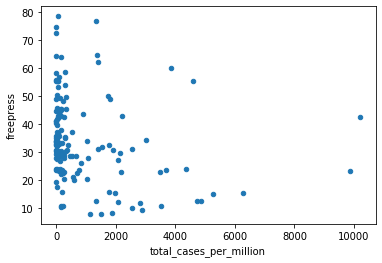

In [30]:
anal.plot.scatter(x='total_cases_per_million',y='freepress')

# two var models

so let's see simple two variable OLS models. we only allow models with 90%+ significance for evary variable. 

In [47]:
combs= itertools.combinations(anal_cols, 2)
var_selection_world_2=pd.DataFrame(columns=['name1','name2','b1','p1','b2','p2','r2','N'])
i=0

for c in combs:
    b=anal[['total_cases_per_million',c[0],c[1]]].dropna()
    if len(b)>10:
        y=b.total_cases_per_million
        x=b[[c[0],c[1]]]
        x=sm.add_constant(x)
        model=sm.OLS(y,x).fit()
        if model.pvalues.values[1]<0.1 and model.pvalues.values[2]<0.1:
            var_selection_world_2.loc[i]=[c[0], c[1], round(model.params[[1]][0],2), model.pvalues.values[1], round(model.params[[2]][0],2), model.pvalues.values[2], round(model.rsquared,2), model.nobs]
            i+=1
var_selection_world_2.sort_values('r2', ascending=False)

,name1,name2,b1,p1,b2,p2,r2,N
50,gdp_per_capita,C4_Restrictions_on_gatherings_1,0.06,1.192718e-06,14.34,4.078819e-02,0.85,18.0
49,gdp_per_capita,C4_Restrictions_on_gatherings_4,0.06,1.707147e-27,-7.04,6.449190e-02,0.71,101.0
47,gdp_per_capita,C7_Restrictions_on_internal_movement_2,0.06,9.204807e-32,-7.47,7.062791e-02,0.69,129.0
48,gdp_per_capita,C6_Stay_at_home_requirements_1,0.05,1.045134e-12,-10.27,4.376880e-02,0.66,52.0
18,median_age,gdp_per_capita,-19.44,6.375842e-02,0.06,1.484453e-27,0.65,147.0
46,gdp_per_capita,hospital_beds_per_100k,0.06,7.228452e-31,-102.74,4.548556e-03,0.65,132.0
51,gdp_per_capita,C2_Workplace_closing_2,0.07,1.898171e-14,-10.71,5.932653e-02,0.64,62.0
103,democracy,C4_Restrictions_on_gatherings_1,24.32,2.410188e-03,27.26,1.487647e-02,0.61,18.0
32,aged_65_older,C4_Restrictions_on_gatherings_1,111.60,5.250475e-03,20.69,7.603676e-02,0.57,18.0
43,aged_70_older,C4_Restrictions_on_gatherings_1,155.40,6.400533e-03,21.04,7.451525e-02,0.56,18.0


In [44]:
b=anal[['total_cases_per_million','aged_65_older','male_smokers']].dropna()
y=b.total_cases_per_million
x=b[['aged_65_older','male_smokers']]
x=sm.add_constant(x)
model=sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     total_cases_per_million   R-squared:                       0.118
Model:                                 OLS   Adj. R-squared:                  0.103
Method:                      Least Squares   F-statistic:                     7.878
Date:                     Mon, 18 May 2020   Prob (F-statistic):           0.000614
Time:                             17:48:00   Log-Likelihood:                -1054.2
No. Observations:                      121   AIC:                             2114.
Df Residuals:                          118   BIC:                             2123.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           998.7136    398.153      2.508      0.013     210.262    1787.165
aged_65_older    73.8800     20.932      3.530      0.001      32.429     115.331
male_smokers    -22.8257     10.451     -2.184      0.031     -43.522      -2.129
==============================================================================
Omnibus:                      113.553   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.481
Skew:                           3.239   Prob(JB):                    2.11e-304
Kurtosis:                      18.344   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

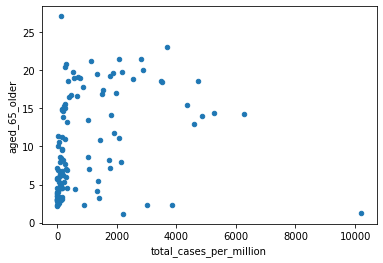

In [45]:
b.plot.scatter(x='total_cases_per_million',y='aged_65_older')